In [1]:
import geopandas as gpd
from dask.distributed import Client, LocalCluster
from dask import delayed, dataframe as dd
from tqdm import tqdm
import dask
import dask_geopandas as dgp
import matplotlib.pyplot as plt
from shapely.geometry import box
from tqdm import tqdm
from shapely.geometry import Point
import libpysal
import pandas as pd
from libpysal.weights import W
import momepy
import pickle

/home/virgilxw/miniconda3/envs/morph_model_v1_tess/lib/python3.11/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 13.0.0. Please consider upgrading.
  warnings.warn(
/home/virgilxw/miniconda3/envs/morph_model_v1_tess/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
place = "glasgow"
local_crs = 27700

In [3]:
tessellation = gpd.read_parquet(f"./output/{place}/tessellation_p1.pq").to_crs(local_crs)
buildings = gpd.read_parquet(f"./output/{place}/buildings_p1.pq").to_crs(local_crs)
streets = gpd.read_parquet(f"./output/{place}/streets_raw.pq").explode().to_crs(local_crs).reset_index(drop=True)

/tmp/ipykernel_2635/3257141034.py:3: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  streets = gpd.read_parquet(f"./output/{place}/streets_raw.pq").explode().to_crs(local_crs).reset_index(drop=True)


In [4]:
# Load your GeoDataFrame
gdf = tessellation

# Calculate the extent of the dataset
bounds = gdf.total_bounds  # [minx, miny, maxx, maxy]

# Modify the create_grid function to include tqdm
def create_grid(bounds, width, height):
    minx, miny, maxx, maxy = bounds
    grid = []
    x_range = range(int((maxx - minx) / width))
    y_range = range(int((maxy - miny) / height))

    for x in tqdm(x_range, desc="Creating Grid"):
        x_coord = minx + x * width
        for y in y_range:
            y_coord = miny + y * height
            grid.append(box(x_coord, y_coord, x_coord + width, y_coord + height))

    return grid

grid_squares = create_grid(bounds, 14000, 14000) 

# Convert to GeoDataFrame
grid_gdf = gpd.GeoDataFrame(geometry=grid_squares)

Creating Grid: 100%|██████████| 5/5 [00:00<00:00, 1778.15it/s]


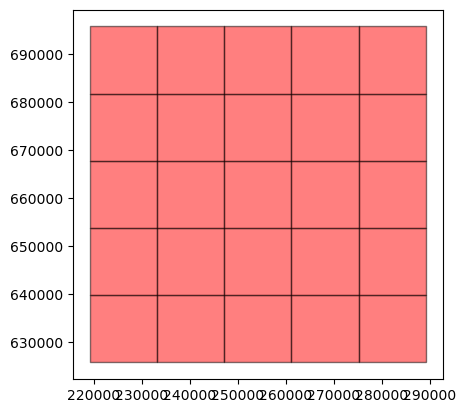

In [5]:
# Optional: Plotting
fig, ax = plt.subplots()
grid_gdf.plot(ax=ax, color='red', alpha=0.5, edgecolor='black')
plt.show()

In [6]:
grid_gdf["uID"] = grid_gdf.index

In [7]:
def find_neighbours(tessellation, cell):
    # Get 'not disjoint' countries
    neighbours = tessellation[~tessellation.geometry.disjoint(cell.geometry)].uID.tolist()
    # Remove own uID of the cell from the list
    neighbours_list = [uID for uID in neighbours if cell.uID != uID]
    return neighbours_list

out = []

for index, cell in grid_gdf.iterrows():
    # Add the delayed task to the current batch
    result = find_neighbours(grid_gdf, cell)
    out.append(result)

In [8]:
grid_gdf["touching"] = out

In [9]:
# Step 1: Calculate centroids
tessellation['centroid'] = tessellation.geometry.centroid

# Step 2: Convert centroids to a new GeoDataFrame
centroids = gpd.GeoDataFrame(tessellation, geometry='centroid')

# Step 3: Perform spatial join
joined_gdf = gpd.sjoin(centroids, grid_gdf, how='inner', op='intersects')

# Step 4: Group original polygons based on the join
grouped_gdf = tessellation.merge(joined_gdf[['centroid', 'index_right']], left_on='centroid', right_on='centroid')


/home/virgilxw/miniconda3/envs/morph_model_v1_tess/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3488: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
/tmp/ipykernel_2635/2368018611.py:8: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:27700
Right CRS: None

  joined_gdf = gpd.sjoin(centroids, grid_gdf, how='inner', op='intersects')


In [10]:

# Assuming you have a GeoDataFrame 'grouped_gdf' and you're grouping by some column 'grouping_column'
grouped = grouped_gdf.groupby('index_right')

# Extracting the uID lists for each group
cells_in_region = {group_name: set(group['uID'].tolist()) for group_name, group in grouped}

In [11]:

# # Assuming 'grouped_gdf' is your grouped GeoDataFrame from the previous steps

# # Plotting
# fig, ax = plt.subplots(figsize=(10, 10))

# # Assign a unique color to each group
# grouped_gdf.plot(column='index_right', ax=ax, legend=True)

# # Optional: Customize the plot
# ax.set_title("Grouped Polygons")
# ax.set_xlabel("Longitude")
# ax.set_ylabel("Latitude")

# # Show the plot
# plt.show()

In [12]:
# Assuming tessellation is a GeoDataFrame
buffered_tessellation = grouped_gdf.buffer(5)

In [13]:
tessellation_a = grouped_gdf

tessellation_a["geometry"] = buffered_tessellation

buffered_tessellation = tessellation_a

In [14]:
buffered_tessellation

,uID,geometry,centroid,index_right
0,894,"POLYGON ((253863.477 668011.585, 253863.109 66...",POINT (253884.307 667999.165),13
1,895,"POLYGON ((252426.697 664330.823, 252426.560 66...",POINT (252446.227 664343.919),12
2,896,"POLYGON ((223823.053 676786.353, 223822.939 67...",POINT (223839.171 676799.209),3
3,897,"POLYGON ((257801.105 660550.010, 257801.203 66...",POINT (257843.194 660543.258),12
4,898,"POLYGON ((253153.012 660405.103, 253151.372 66...",POINT (253165.545 660418.483),12
...,...,...,...,...
497512,550834,"POLYGON ((282829.274 655303.932, 282831.275 65...",POINT (282837.488 655294.819),22
497513,550835,"POLYGON ((262699.032 653302.069, 262699.223 65...",POINT (262722.428 653287.169),16
497514,550836,"POLYGON ((271177.635 645473.818, 271178.052 64...",POINT (271242.370 645492.275),16
497515,550837,"POLYGON ((261655.213 651822.788, 261655.252 65...",POINT (261670.104 651841.474),16


In [15]:
cells_in_expanded_region = cells_in_region

for index, region in tqdm(grid_gdf.iterrows(), total=grid_gdf.shape[0]):
    expanded_cells = buffered_tessellation[buffered_tessellation['index_right'].isin(region.touching)]

    intersection_rows = expanded_cells[expanded_cells.intersects(region.geometry)]
    
    cells_in_expanded_region[index].union(set(intersection_rows.uID.tolist()))
    

100%|██████████| 25/25 [00:02<00:00, 11.22it/s]


In [16]:
list_of_weights = []

for index, expanded_region in tqdm(grid_gdf.iterrows(), total=grid_gdf.shape[0]):
    expanded_cell_gdf = tessellation[tessellation['uID'].isin(list(cells_in_expanded_region[index]))]
    
    list_of_weights.append(libpysal.weights.fuzzy_contiguity(expanded_cell_gdf, tolerance=0.05, buffering=True, drop=True, buffer=5, ids="uID", silence_warnings=True))


  0%|          | 0/25 [00:00<?, ?it/s]/home/virgilxw/miniconda3/envs/morph_model_v1_tess/lib/python3.11/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/virgilxw/miniconda3/envs/morph_model_v1_tess/lib/python3.11/site-packages/libpysal/weights/util.py:1674: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gdf.drop(columns=["_buffer"], inplace=True)
  4%|▍         | 1/25 [00:01<00:25,  1.05s/it]/home/virgilxw/miniconda3/envs/morph_model_v1_tess/lib/python3.11/site-packages/geopandas/geod

In [17]:
list_of_weights

In [18]:
adjlist_combined = None
for index, weight in tqdm(enumerate(list_of_weights), total= len(list_of_weights)):
    
    adjlist = list_of_weights[index].to_adjlist()
    
    adjlist = adjlist[adjlist["focal"].isin(cells_in_region[index])]
    
    if index == 0:
        adjlist_combined = adjlist
    
    else:
        adjlist_combined = pd.concat([adjlist_combined, adjlist])

100%|██████████| 25/25 [00:04<00:00,  5.34it/s]


In [19]:
queen_1 = W.from_adjlist(adjlist_combined)

/home/virgilxw/miniconda3/envs/morph_model_v1_tess/lib/python3.11/site-packages/libpysal/weights/weights.py:224: UserWarning: The weights matrix is not fully connected: 
 There are 70 disconnected components.
 There are 11 islands with ids: 28945.0, 60828.0, 99834.0, 117373.0, 206542.0, 226173.0, 248635.0, 353759.0, 434997.0, 534628.0, 545486.0.
  warnings.warn(message)


In [20]:
queen_3 = momepy.sw_high(k=3, weights=queen_1)

In [22]:
with open(f'output/{place}/queen_1.pkl', 'wb') as file:
    pickle.dump(queen_1, file)
    file.close()
    
with open(f'output/{place}/queen_3.pkl', 'wb') as file:
    pickle.dump(queen_3, file)
    file.close()